In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.applications import VGG19, ResNet50, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LambdaCallback

In [3]:
# Load data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv') 

# Define emotion dictionary and labels
emotion_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_labels = list(emotion_dict.values())

In [4]:
train_samples = train.shape[0]

# Đếm số lượng mẫu trong tập test
test_samples = test.shape[0]

# In ra số lượng mẫu
print(f"Số lượng mẫu trong tập train: {train_samples}")
print(f"Số lượng mẫu trong tập test: {test_samples}")

Số lượng mẫu trong tập train: 28709
Số lượng mẫu trong tập test: 7178


In [10]:
 
emotion_counts_train = train['emotion'].value_counts(sort=False).reset_index()
emotion_counts_train.columns = ['emotion', 'train number']
emotion_counts_train['emotion'] = emotion_counts_train['emotion'].map(emotion_dict)
#emotion_counts_train

emotion_counts_test = test['emotion'].value_counts(sort=False).reset_index()
emotion_counts_test.columns = ['emotion', 'test number']
emotion_counts_test['emotion'] = emotion_counts_test['emotion'].map(emotion_dict)
#emotion_counts_test

# Gộp hai bảng lại với nhau bằng cách nối theo cột
emotion_counts = pd.merge(emotion_counts_train, emotion_counts_test, on='emotion', how='outer')

# Hiển thị
#emotion_counts
# Total 'train number' and 'test number'
total_train = emotion_counts['train number'].sum()
total_test = emotion_counts['test number'].sum()

# Create total row
total_row = pd.DataFrame([['Total', total_train, total_test]], columns=['emotion', 'train number', 'test number'])

# Add total row in emotion_counts
emotion_counts_with_total = pd.concat([emotion_counts, total_row], ignore_index=True)

# show
emotion_counts_with_total


,emotion,train number,test number
0,Angry,3995,958
1,Disgust,436,111
2,Fear,4097,1024
3,Happy,7215,1774
4,Neutral,4965,1233
5,Sad,4830,1247
6,Surprise,3171,831
7,Total,28709,7178


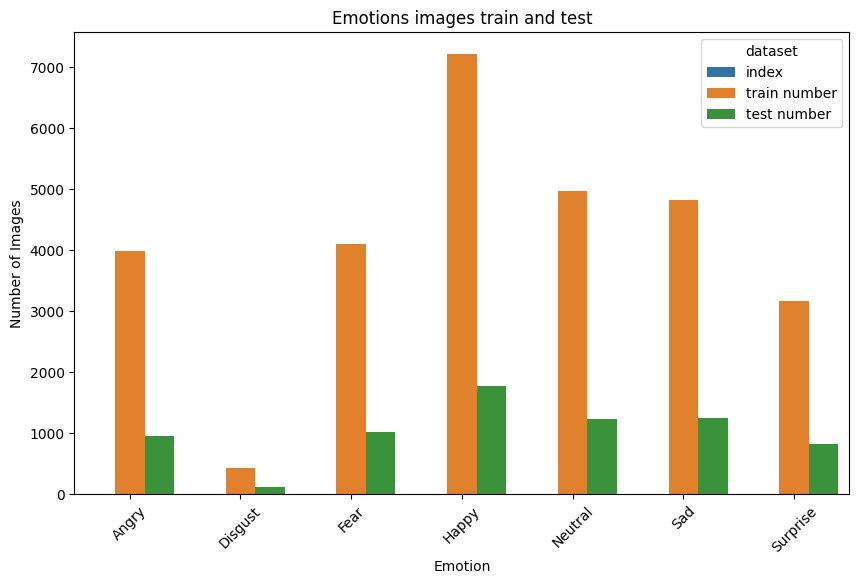

In [11]:
# Chuyển bảng về dạng thích hợp cho seaborn
emotion_counts_melted = emotion_counts.reset_index().melt(id_vars='emotion', var_name='dataset', value_name='number')

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
sns.barplot(x='emotion', y='number', hue='dataset', data=emotion_counts_melted)

# Thêm tiêu đề và nhãn
plt.title('Emotions images train and test')
plt.xlabel('Emotion')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)

# Hiển thị biểu đồ
plt.show()

In [5]:
def process_pixels(data):
    # Kiểm tra loại dữ liệu của 'pixels'
    if isinstance(data['pixels'].iloc[0], str):  # Nếu là chuỗi
        data['pixels'] = data['pixels'].apply(lambda x: np.array(x.split(), dtype='float32') / 255.0)
    elif isinstance(data['pixels'].iloc[0], np.ndarray):  # Nếu là numpy array
        data['pixels'] = data['pixels'].apply(lambda x: x / 255.0)
    return data

# Xử lý cả 2 tập dữ liệu
train = process_pixels(train)
test = process_pixels(test) 

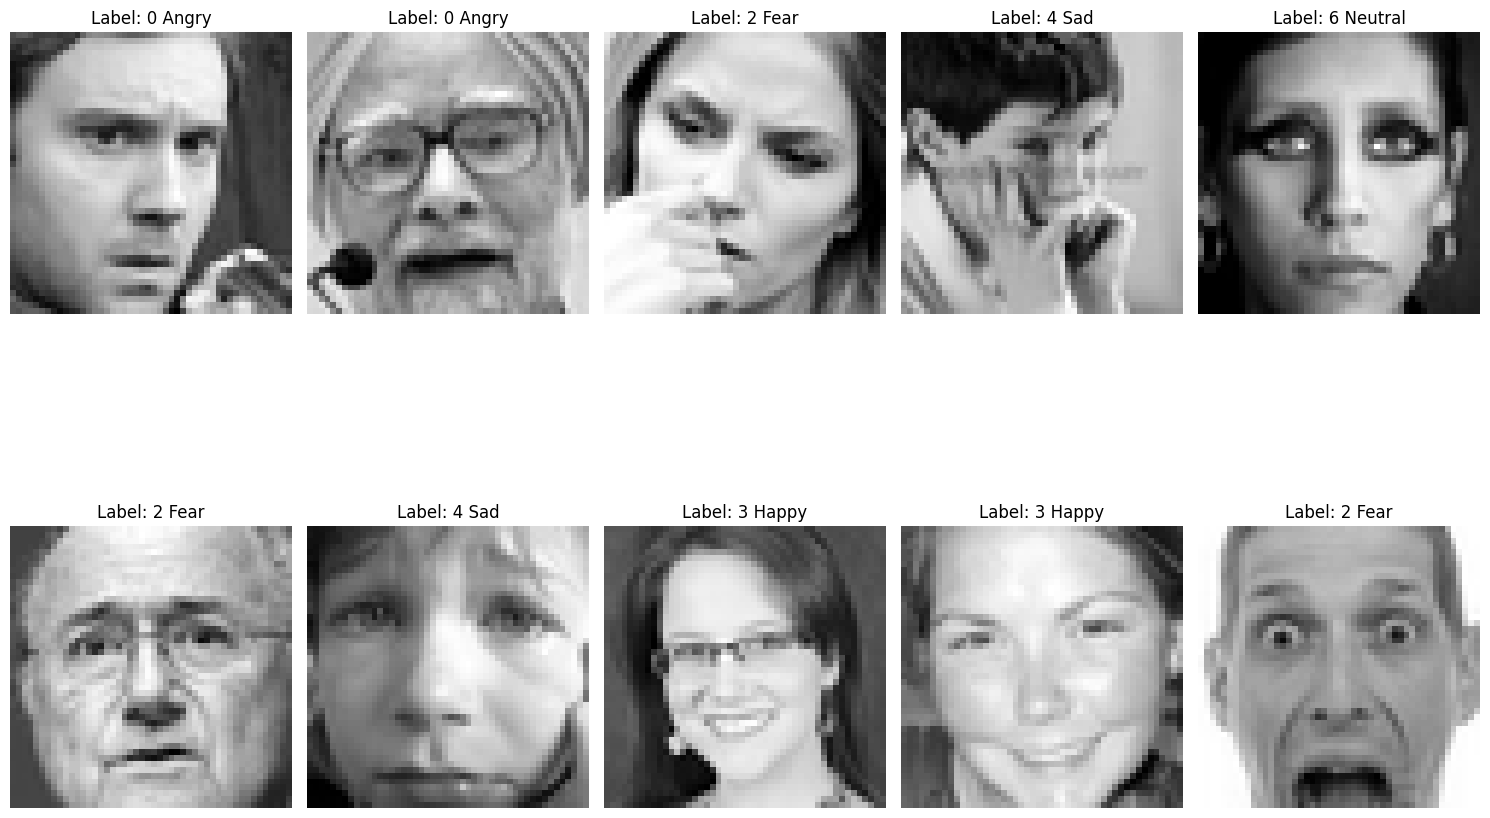

In [6]:
# Display 10 sample images
def display_sample_images(data, num_images=10, set_type='train'):
    # Create a dictionary to map numerical labels to emotion names
    
    
    # Set up the plot grid
    rows = num_images // 5 if num_images % 5 == 0 else (num_images // 5) + 1
    fig, axes = plt.subplots(rows, 5, figsize=(15, 6 * rows))
    
    # Flatten axes in case of multiple rows
    axes = axes.flat if num_images > 1 else [axes]

    for i, ax in enumerate(axes[:num_images]):
        # Get the pixel data from the DataFrame
        image = data['pixels'].iloc[i].reshape(48, 48)
        
        # Get the emotion label and map it to the corresponding emotion name
        emotion_label = data['emotion'].iloc[i]
        emotion_name = emotion_dict[emotion_label]
        
        # Display the image
        ax.imshow(image, cmap='gray')
        ax.set_title(f"Label: {emotion_label} {emotion_name}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

display_sample_images(train, num_images=10, set_type='train')

In [31]:
#Dataset processing

# Reshape lại dữ liệu thành 48x48x1
X_train = np.array(train['pixels'].tolist()).reshape(-1, 48, 48, 1)
X_test = np.array(test['pixels'].tolist()).reshape(-1, 48, 48, 1)

y_train = tf.keras.utils.to_categorical(train['emotion'], num_classes=7)
y_test = tf.keras.utils.to_categorical(test['emotion'], num_classes=7) 

# Chia dữ liệu thành tập validation
X_train_resized, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)



In [54]:
# Model creation functions
def vgg19_model():
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    base_model.trainable = False

    #model.summary()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def resnet50_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    base_model.trainable = False

    #model.summary()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def mobilenetv2_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(160, 160, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    base_model.trainable = False

    #model.summary()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, kernel_initializer='he_uniform', activation='relu'),
        Dropout(0.5),
        Dense(7, activation='softmax')
    ])
    #model.summary()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [55]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
# print_callback = LambdaCallback(on_epoch_end=lambda epoch, 
#                                 logs: print(f"Epoch {epoch+1}: Loss={logs['loss']:.4f}, Accuracy={logs['accuracy']:.4f}"))

def on_epoch_end(epoch, logs):
    if (epoch + 1) % 10 == 0:  # Cập nhật điều kiện để hiển thị mỗi 10 epoch
        print(f"Epoch {epoch+1}:")
        print(f" - loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f}")
        print(f" - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)



In [56]:
# Function to resize images according to model requirements
def resize_for_model(X, model_name):
    if model_name == 'VGG19' or model_name == 'ResNet50':
        return tf.image.resize(np.repeat(X, 3, axis=-1), (224, 224)).numpy()
    elif model_name == 'MobileNetV2':
        return tf.image.resize(np.repeat(X, 3, axis=-1), (160, 160)).numpy()
    else:  # CustomCNN
        return X  # No resizing  (48x48x1) 

In [57]:
# Data augmentation with resizing in the pipeline (model deep CNN)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data augmentation with resizing in the pipeline
datagen2 = ImageDataGenerator(
    rotation_range=20, 
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [58]:
models = {
    'CustomCNN': cnn_model(),
    'VGG19': vgg19_model(),
    'ResNet50': resnet50_model(),
    'MobileNetV2': mobilenetv2_model()
}

for name, model in models.items():
    print(f"Model: {name}")
    model.summary()


Model: CustomCNN


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,743 (1.36 MB)

 Trainable params: 356,295 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

Model: VGG19


Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_33     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,157,511 (76.89 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

Model: ResNet50


Model: "functional_46"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_46      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_46[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 526,343 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Model: MobileNetV2


Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_47      │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_47[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,587,719 (9.87 MB)

 Trainable params: 329,735 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [59]:
# Train models

histories = {}

# Train models
for name, model in models.items():

    print(f"Training {name}...")


    # Resizing the training and validation data
    X_train_resized = resize_for_model(X_train_resized, name)
    X_val_resized = resize_for_model(X_val, name)

    train_generator = datagen.flow(X_train_resized, y_train, batch_size=64)
    train_generator2 = datagen2.flow(X_train_resized, y_train, batch_size=64)
    
    if name == 'VGG19' or name == 'ResNet50' or name == 'MobileNetV2':
        history = model.fit( 
            train_generator2,
            epochs=30,
            validation_data=(X_val_resized, y_val),
            callbacks=[print_callback, early_stopping, reduce_lr]
        )
    else:
        # Dữ liệu không thay đổi kích thước, sử dụng trực tiếp
        train_cnn_generator = datagen.flow(X_train_resized, y_train, batch_size=64)

        history = model.fit(
            train_generator,
            epochs=100,
            validation_data=(X_val_resized, y_val),
            callbacks=[print_callback, early_stopping, reduce_lr]
        )

    histories[name] = history

Training CustomCNN...
Epoch 1/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 48s 124ms/step - accuracy: 0.2106 - loss: 2.0556 - val_accuracy: 0.2574 - val_loss: 1.8895 - learning_rate: 0.0010
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 42s 115ms/step - accuracy: 0.2522 - loss: 1.8111 - val_accuracy: 0.2661 - val_loss: 1.7340 - learning_rate: 0.0010
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 40s 112ms/step - accuracy: 0.2608 - loss: 1.7820 - val_accuracy: 0.2964 - val_loss: 1.7087 - learning_rate: 0.0010
Epoch 4/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 41s 113ms/step - accuracy: 0.2775 - loss: 1.7493 - val_accuracy: 0.3304 - val_loss: 1.7314 - learning_rate: 0.0010
Epoch 5/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - accuracy: 0.2933 - loss: 1.6941 - val_accuracy: 0.4180 - val_loss: 1.5077 - learning_rate: 0.0010
Epoch 6/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - accuracy: 0.3199 - loss: 1.6642 - val_accuracy: 0.3041 - val_loss: 1.7016 - learning_rate: 0.0010
Epoch 7/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 4

: 

In [ ]:
# Evaluate models
for name, model in models.items():
    print(f"Evaluating {name}...")
    X_test_resized = resize_for_model(X_test, name)
    
    loss, accuracy = model.evaluate(X_test_resized, y_test)
    print(f"{name} accuracy: {accuracy:.2f}")
    
    # Save model
    model.save(f'{name}_model.keras')

In [1]:
# Plot confusion matrix
for name, model in models.items():
    X_test_resized = resize_for_model(X_test, name)
    y_pred = model.predict(X_test_resized)
    
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

     # Tính toán báo cáo phân loại
    class_report = classification_report(y_true_classes, y_pred_classes, target_names=list(emotion_dict.values()))


    
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=list(emotion_dict.values()), 
                yticklabels=list(emotion_dict.values()))
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    # Hiển thị báo cáo phân loại
    print(f'Classification Report for {name}:\n')
    print(class_report)
    print('-----------------------------------\n')
    


NameError: name 'models' is not defined

In [ ]:
# Hiển thị báo cáo phân loại
#print(classification_report(y_test_classes, y_pred_classes, target_names=emotion_labels))

In [ ]:
def plot_original_and_predicted(X, y_true, y_pred, emotion_dict, num_samples=5):
    # Chọn một số mẫu ngẫu nhiên từ tập dữ liệu
    indices = np.random.choice(range(len(X)), num_samples, replace=False)
    
    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(indices):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(X[idx].reshape(48, 48), cmap='gray')  # Reshape ảnh thành 48x48 nếu cần
        true_label = emotion_dict[np.argmax(y_true[idx])]
        plt.title(f"True: {true_label}")
        plt.axis('off')
        
        plt.subplot(2, num_samples, num_samples + i + 1)
        pred_label = emotion_dict[np.argmax(y_pred[idx])]
        plt.imshow(X[idx].reshape(48, 48), cmap='gray')  # Hiển thị ảnh dự đoán cùng với ảnh gốc
        plt.title(f"Pred: {pred_label}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Giả sử models là một dictionary chứa các mô hình
for name, model in models.items():
    # Resize dữ liệu đầu vào cho mô hình nếu cần
    X_test_resized = resize_for_model(X_test, name)
    
    # Dự đoán
    y_pred = model.predict(X_test_resized)
    
    # Hiển thị ảnh gốc và ảnh dự đoán
    print(f"Original and predicted images for {name}:")
    plot_original_and_predicted(X_test, y_test, y_pred, emotion_dict, num_samples=5)